In [2]:
import pandas as pd
import numpy as np
from nltk import *
import matplotlib.pyplot as plt
import jieba.posseg as pseg
import jieba
from jieba import analyse 
# 引入TextRank关键词抽取接口 
textrank = analyse.textrank # 原始文本 
tfidf = analyse.extract_tags

In [3]:
df_train = pd.read_csv('../datas/train_set.csv',encoding='utf8')

In [4]:
set(df_train['class'].values)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [5]:
df_train.head()

,id,article,word_seg,class
0,0,7368 1252069 365865 755561 1044285 129532 1053...,816903 597526 520477 1179558 1033823 758724 63...,14
1,1,581131 165432 7368 957317 1197553 570900 33659...,90540 816903 441039 816903 569138 816903 10343...,3
2,2,7368 87936 40494 490286 856005 641588 145611 1...,816903 1012629 957974 1033823 328210 947200 65...,12
3,3,299237 760651 299237 887082 159592 556634 7489...,563568 1239563 680125 780219 782805 1033823 19...,13
4,4,7368 7368 7368 865510 7368 396966 995243 37685...,816903 816903 816903 139132 816903 312320 1103...,12


In [6]:
df_train_token = df_train['word_seg']

In [7]:
##制作词典
train_token = [word for line in df_train_token.values for word in line.split(' ')]

In [8]:
len(set(train_token))

875129

In [9]:
for word in distinct_words:
    #读取人工标记的词典，调用jieba的add_word方法增加词和词对应的词性【不是语法上的词性，而是特定领域定义的专有词性】
    jieba.add_word(word.strip(),tag='daguan')
    jieba.suggest_freq(word.strip())

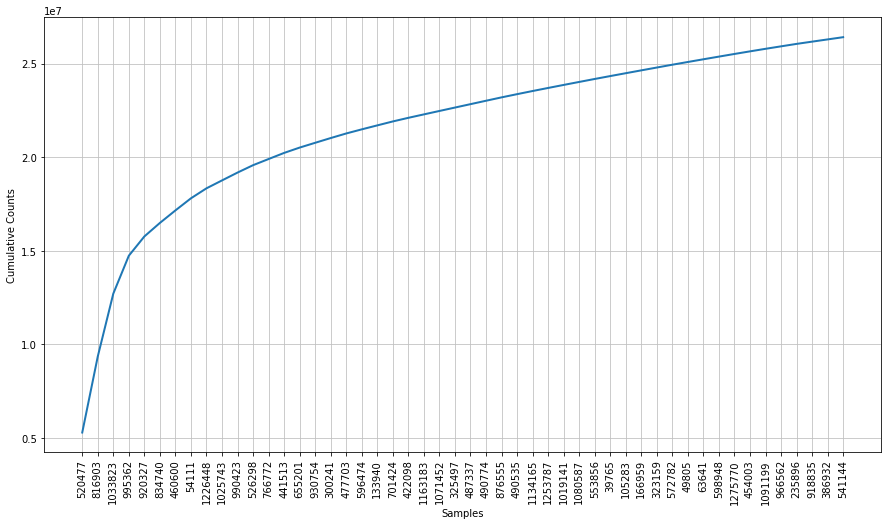

In [10]:
#过滤掉高频和低频词
from nltk import *
import matplotlib.pyplot as plt
fdist = FreqDist(train_token)
plt.figure(figsize=(15,8))
fdist.plot(50,cumulative=True)

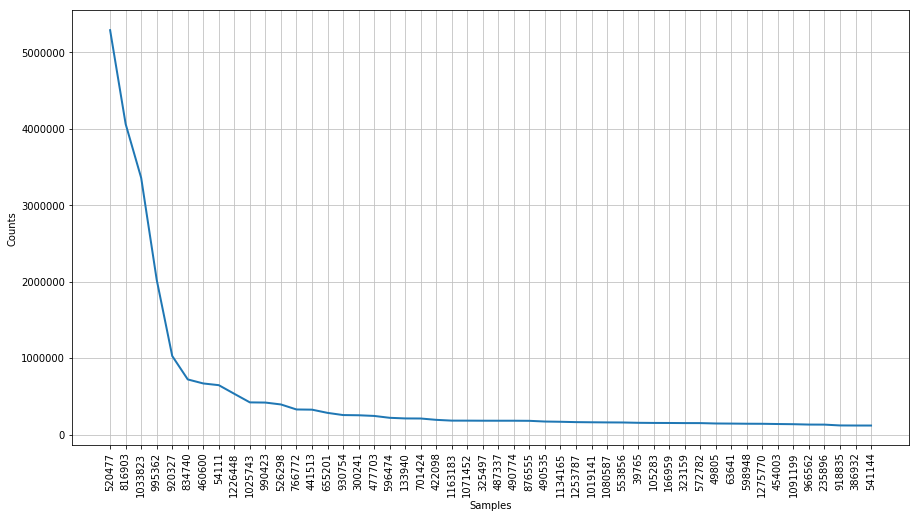

In [11]:
plt.figure(figsize=(15,8))
fdist.plot(50,cumulative=False)

In [12]:
most_common_token = set([i[0] for i in fdist.most_common()[:10]])
most_common_token
hapaxes = set(fdist.hapaxes())
len(hapaxes)

408164

In [13]:
### 去除高频词好低频词
filterd_token = [token for token in train_token if token not in hapaxes and token not in most_common_token]
print(len(train_token),len(filterd_token),len(set(filterd_token)))

73327966 54159981 466955


In [14]:
def build_vocab(filterd_tokens, vocab_size=400000):
    """根据训练集构建词汇表，存储"""
    counter = Counter(filterd_tokens)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    return words
total_words = build_vocab(filterd_token)

In [15]:
train_token.clear()
filterd_token.clear()
df_train = None

In [18]:
df_test = pd.read_csv('../datas/test_set.csv',encoding='utf8')
df_test_token = df_test['word_seg']
test_token = [word for line in df_test_token.values for word in line.split(' ')]
### 去除高频词好低频词
filterd_token = [token for token in test_token if token not in hapaxes and token not in most_common_token]
print(len(test_token),len(filterd_token),len(set(filterd_token)))
test_total_words = build_vocab(filterd_token)
a = set(total_words)
b = set(test_total_words)
final_total_words = [total_words.append(token) for token in b if  token not in a]
print(len(total_words),len(final_total_words))

73440220 54420755 763537
506644 96748


In [20]:
df_test = None
#df_test_token.clear()
filterd_token.clear()

In [21]:
with open('total_words','w',encoding='utf8') as f:
    f.write('\n'.join(total_words) + '\n')
np.save('total_words',total_words)
#保存词典
distinct_words = list(set(total_words))
np.save('distinct_words',distinct_words)

### 最重要的操作来了 ！！！

In [3]:
distinct_words = np.load('distinct_words.npy')
for word in distinct_words:
    #读取人工标记的词典，调用jieba的add_word方法增加词和词对应的词性【不是语法上的词性，而是特定领域定义的专有词性】
    jieba.add_word('daguan'+word.strip(),tag='daguan')
    jieba.suggest_freq(word.strip())

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\admin\AppData\Local\Temp\jieba.cache
Loading model cost 0.819 seconds.
Prefix dict has been built succesfully.


In [4]:
df_train_token = pd.read_csv('../datas/train_set.csv',encoding='utf8')['word_seg']
df_test_token = pd.read_csv('../datas/test_set.csv',encoding='utf8')['word_seg']

In [7]:
##对句子进行主题提取
train_keywords = []
def f():
    dd = ["daguan"+"daguan".join([i for i in line.split(" ")]) for line in df_train_token.values]
    [train_keywords.append(tfidf(line,topK=100,withWeight=True,allowPOS=('daguan',))) for line in dd]
import threading
threading.Thread(target=f, name='LoopThread').start()

In [19]:
train_topics = [[token[0][6:] for token in line] for line in train_keywords]

In [22]:
np.save('train_topics',train_topics)

In [23]:
test_keywords = []
def ff():
    dd = ["daguan"+"daguan".join([i for i in line.split(" ")]) for line in df_test_token.values]
    [test_keywords.append(tfidf(line,topK=100,withWeight=True,allowPOS=('daguan',))) for line in dd]
import threading
threading.Thread(target=ff, name='LoopThread').start()

In [30]:
test_topics = [[token[0][6:] for token in line] for line in test_keywords]
np.save('test_topics',test_topics)

### 使用测试集合训练集中出现过得关键词，构建词典


In [31]:
all_topic = train_topics + test_topics

In [33]:
len(all_topic)

204554

In [34]:
all_topic_phrase = set([phrase for line in all_topic for phrase in line])

In [35]:
len(all_topic_phrase)

348705

In [38]:
def build_vocab(filterd_tokens, vocab_size=300000):
    """根据训练集构建词汇表，存储"""
    counter = Counter(filterd_tokens)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    return words
total_words = build_vocab(list(all_topic_phrase))

In [41]:
##构建词典索引映射
def build_word_to_id():
    word_to_id = dict(zip(total_words, range(len(total_words))))
    return word_to_id
phrase_to_id = build_word_to_id()

In [43]:
np.save('all_phrase',total_words)

In [44]:
np.save('phrase_to_id',phrase_to_id)

## 用构建好的词典去获取测试集合训练集关键词的映射ID

In [47]:
train_phrases = [[phrase_to_id.get(word) for word in line] for line in train_topics]
test_phrases = [[phrase_to_id.get(word) for word in line] for line in test_topics]

In [50]:
np.save('train_phrases',train_phrases)
np.save('test_phrases',test_phrases)

In [51]:
len(train_phrases[0])

100